In [1]:
import os, platform
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories,
 on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [6]:
# Preprocessing
test_shop_index = test['shop_id'].unique()
test_item_index = test['item_id'].unique()
 
lk_train = train[train['shop_id'].isin(test_shop_index)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_index)]
 
lk_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.0,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,2013-03-01,0,25,2574,399.0,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,2013-05-01,0,25,2574,399.0,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
12,2013-07-01,0,25,2574,399.0,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
13,2013-08-01,0,25,2574,399.0,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [7]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.0,1
10,2013-03-01,0,25,55,2574,399.0,2
11,2013-05-01,0,25,55,2574,399.0,1
12,2013-07-01,0,25,55,2574,399.0,1
13,2013-08-01,0,25,55,2574,399.0,2
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,55,7409,299.0,1
2935845,2015-09-10,33,25,55,7460,299.0,1
2935846,2015-10-14,33,25,55,7459,349.0,1
2935847,2015-10-22,33,25,57,7440,299.0,1


In [8]:
print(train_monthly.isnull().sum())

date                0
date_block_num      0
shop_id             0
item_category_id    0
item_id             0
item_price          0
item_cnt_day        0
dtype: int64


In [9]:
# Calculate the total and average monthly sales and prices of different stores and items
train_monthly = train_monthly.sort_values('date').groupby(
    ['date_block_num', 'shop_id', 'item_category_id', 'item_id'],
    as_index=False
)

In [10]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 
                         'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.000000,1532.857178,9,1.285714,7
1,0,2,2,5643,4775.209961,2387.604980,0,0.000000,2
2,0,2,5,5583,1188.300049,594.150024,2,1.000000,2
3,0,2,6,7893,5970.000000,1990.000000,3,1.000000,3
4,0,2,6,7894,1490.000000,1490.000000,1,1.000000,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.000000,4390.000000,1,1.000000,1
600155,33,59,79,17717,8025.500000,802.549988,13,1.300000,10
600156,33,59,83,22087,357.000000,119.000000,6,2.000000,3
600157,33,59,83,22088,238.000000,119.000000,2,1.000000,2


In [11]:
# There may be incompatible combinations of stores and products in the test set, so we expand the training set
shop_index = train_monthly['shop_id'].unique()
item_index = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_index:
        for item in item_index:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
empty_df

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894
...,...,...,...
6734443,33,36,9103
6734444,33,36,9107
6734445,33,36,5704
6734446,33,36,12733


In [12]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
 
train_monthly.fillna(0, inplace=True)
 
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [13]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


In [14]:
# EDA
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

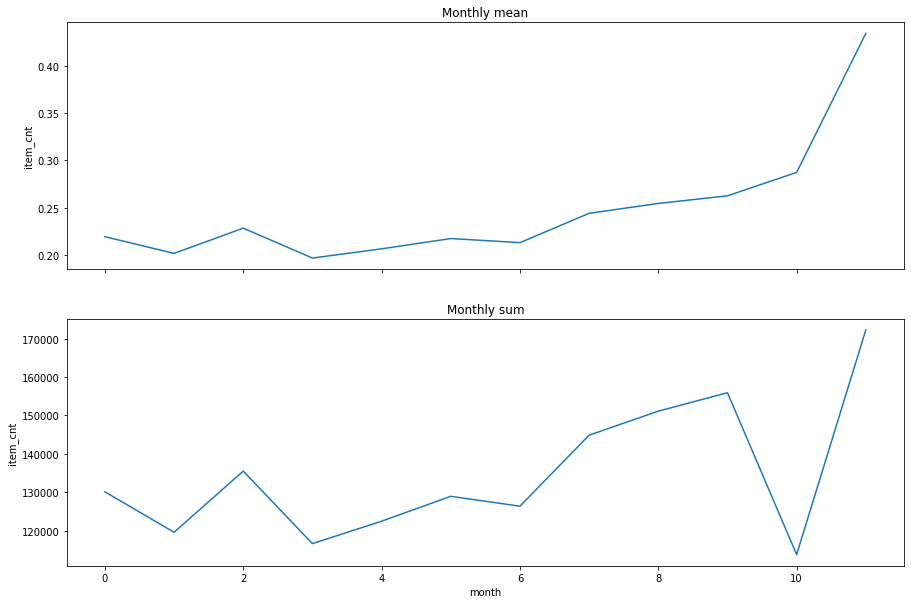

In [15]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

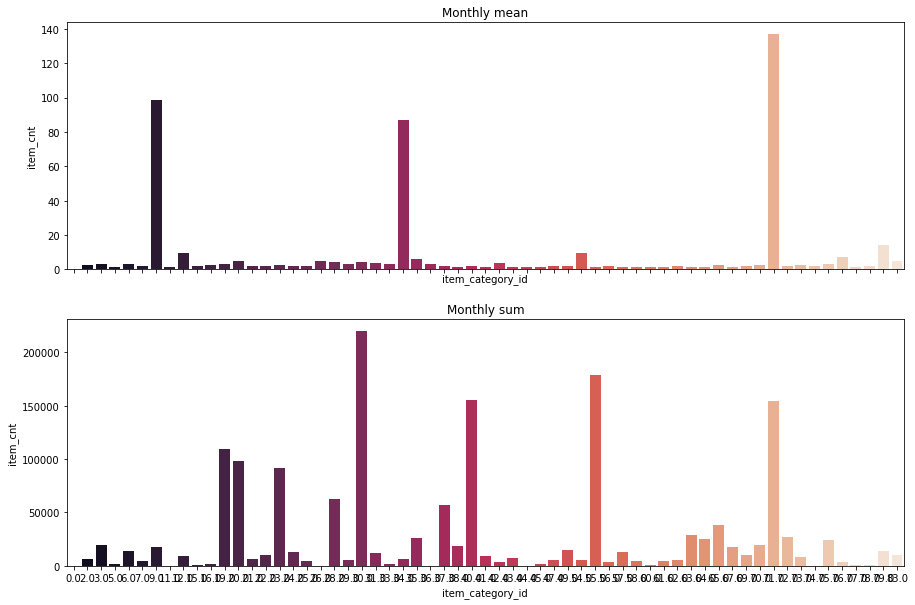

In [16]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

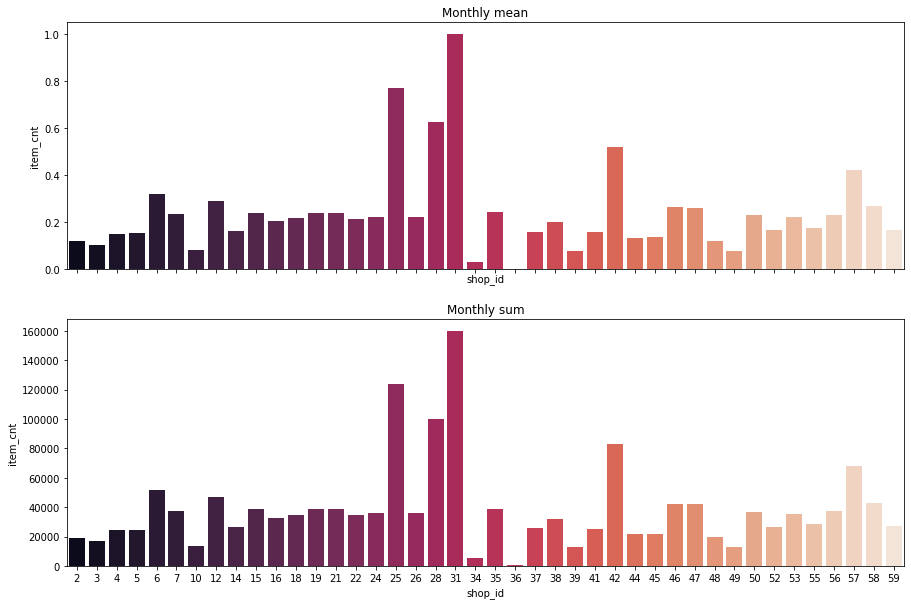

In [17]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

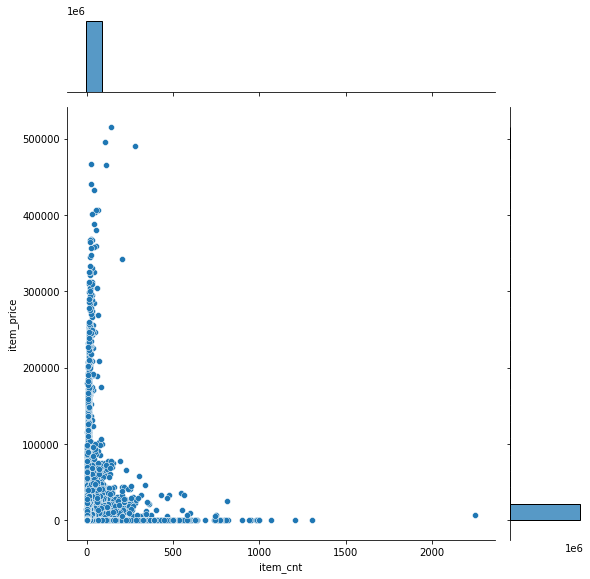

In [18]:
# Find outliers through scatter plots and box plots
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

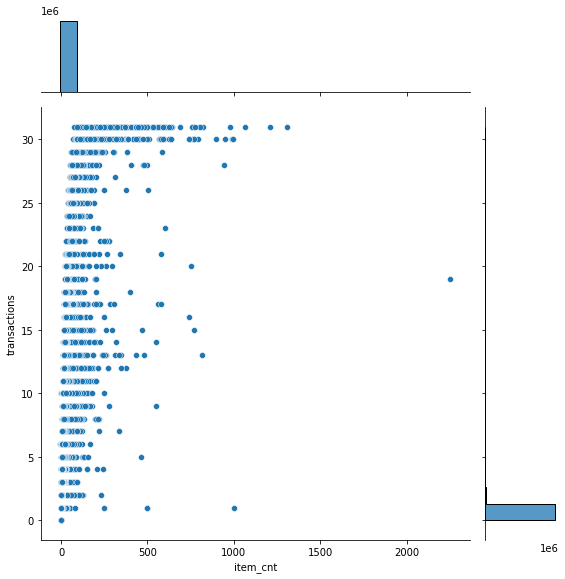

In [19]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

/Users/yingchenghan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


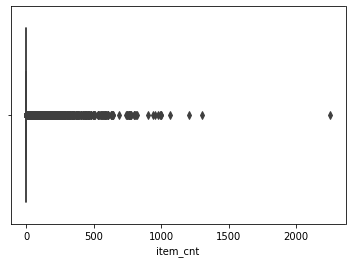

In [20]:
plt.subplots()
sns.boxplot(train_monthly["item_cnt"])
plt.show()

In [21]:
# Exclude data with sales exceeding 20 or selling prices exceeding 40,0000
train_monthly = train_monthly.query('item_cnt>=0 and item_cnt<=20 and item_price<400000')
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


In [22]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

<ipython-input-22-167d96828c02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)


In [23]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)
train_monthly.head()

<ipython-input-23-5a8ca7085388>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
/Users/yingchenghan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0,1192.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0,inf
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0,594.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0,1990.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0,1490.0


In [24]:
# Calculate price fluctuations for each 
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'min_item_price', 'max_item_price']
 
train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')
 
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['min_item_price']
train_monthly['price_decrease'] = train_monthly['max_item_price'] - train_monthly['item_price']

train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,min_item_price,max_item_price,price_increase,price_decrease
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,10730.000000,8249.500000
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0,inf,0.0,35260.0,4775.209961,30484.789062
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0,594.0,0.0,5592.0,1188.300049,4403.700195
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0,1990.0,0.0,27950.0,5970.000000,21980.000000
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0,1490.0,0.0,25880.0,1490.000000,24390.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728113,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,500.0,0.000000,500.000000
6728114,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,300.0,0.000000,300.000000
6728115,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,1750.0,0.000000,1750.000000
6728116,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,2980.0,0.000000,2980.000000


In [25]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()
 
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']
 
for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

In [26]:
# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [31]:
lag_list = [1, 2, 3]
 
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [34]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,...,18979.5,10730.000000,8249.500000,9.0,9.0,9.0,0.0,0.0,0.0,0.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,...,35260.0,4775.209961,30484.789062,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,...,5592.0,1188.300049,4403.700195,2.0,2.0,2.0,0.0,0.0,0.0,0.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,...,27950.0,5970.000000,21980.000000,3.0,3.0,3.0,0.0,0.0,0.0,0.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,...,25880.0,1490.000000,24390.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [35]:
train_monthly['item_trend'] = train_monthly['item_cnt']
 
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

In [36]:
train_monthly['item_trend'] /= len(lag_list) + 1

In [58]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()
 
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)
 
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [59]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

In [60]:
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [61]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [62]:
# Integer features
int_features = ['shop_id', 'item_id', 'year', 'month']
 
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [63]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.head().append(X_test.tail())
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [64]:
sets = [X_train, X_validation, X_test]
 
            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [65]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [68]:
X_train

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2.0,5572.0,2980.0,1490.0,2.0,1.0,2.0,2013.0,3.0,1490.0,...,0.577350,1.0,1.0,9.0,-2.25,0.097844,1.004766,0.84,0.135041,0.15732
1,2.0,5643.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,1.818702,1.84,0.135041,0.15732
2,2.0,5583.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,0.589524,0.04,0.135041,0.15732
3,2.0,7893.0,9350.0,1870.0,5.0,1.0,5.0,2013.0,3.0,1870.0,...,2.081666,1.0,2.0,3.0,-0.25,0.097844,3.038388,3.12,0.135041,0.15732
4,2.0,7894.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,3.670837,1.68,0.135041,0.15732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946780,36.0,9103.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946781,36.0,9107.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946782,36.0,5704.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946783,36.0,12733.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732


In [69]:
X_test

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5.0,5037.0,749.5,749.5,1.0,1.0,1.0,2015.0,9.0,749.0,...,1.154701,3.0,1.0,1.0,-1.00,0.134691,0.703527,0.28,0.22495,0.167111
1,5.0,5320.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.053333,0.00,0.22495,0.167111
2,5.0,5233.0,2997.0,999.0,3.0,1.0,3.0,2015.0,9.0,999.0,...,1.000000,1.0,2.0,3.0,-0.75,0.134691,0.071429,0.12,0.22495,0.167111
3,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.000000,0.00,0.22495,0.167111
4,5.0,5268.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.053333,0.00,0.22495,0.167111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45.0,18454.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.403810,0.32,0.22495,0.167111
214196,45.0,16188.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.000000,0.00,0.22495,0.167111
214197,45.0,15757.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.230476,0.24,0.22495,0.167111
214198,45.0,19648.0,0.0,0.0,0.0,0.0,0.0,2015.0,9.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.030476,0.00,0.22495,0.167111


In [66]:
# Use only part of features on random forest.
from sklearn.ensemble import RandomForestRegressor

rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]
 
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [70]:
from sklearn.metrics import mean_squared_error
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)
 
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6985868322226099
Validation rmse: 0.776123635046122


In [71]:
#Linear Reg
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]
 
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)
 
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [72]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

print("Train rmse:", np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print("Valiadation rmse:", np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132326333323
Valiadation rmse: 0.775531109353346


In [73]:
from sklearn.neighbors import KNeighborsRegressor

knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']
 
# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]
 
knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]
 
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)
 
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [74]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)
 
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.48661440612348666
Validation rmse: 0.80036105644979
